# Pytorch Lightning - HedgeNet

<img src="hedgenet-archi.jpg" width="920">

L2 regularization is implemented via weight decay in the optimizer.

### Normal features (M0, tau0_implvol0)
- v1.0.0: (30, 30) Same parameters as in the paper (Adam optimizer + regularization(1e-3) on 2 first layers only, ReLu, LR=1e-4, No scheduler), limited to 72 epochs, batch size=64 - Best CV (MSE)=0.00124
- v1.0.4: (30, 30) AdamW optimizer + default regularization (1e-2) + ReLu, CosineLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00121
- v1.1.0: (30, 30) AdamW optimizer + default regularization (1e-2) + GeLu, Drop rate=0.1, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00158
- v1.2.0: (32, 16, 8) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0.1, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00301
- v1.3.0: (32, 32) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=**0.00116**
- v1.4.0: (32, 32) AdamW optimizer + default regularization (1e-2) + SiLu, Drop rate=0, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00156

<img src="lightning.jpg" width="640">

### Normal features (M0, tau0_implvol0) with EMA:
- v1.4.1: (32, 32) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00130
- v1.4.1: (32, 32) AdamW optimizer + default regularization (1e-2) + GeLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00162
- v1.4.2: (100, 100) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00126
- v1.4.3: (192, 192) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 96 epochs, batch size=64 - Best CV (MSE)=0.00124
- v1.4.4: (256, 256) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=**0.00120**
- v1.4.5: (512, 512) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00123

<img src="lightning-ema.jpg" width="640">

### Delta-vega features (delta_bs, 1_over_sqrt_tau, vega_n) with EMA:
- v1.4.4: (256, 256) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00122

### Delta-vega-vanna features (delta_bs, 1_over_sqrt_tau, vega_n, vanna_n) with EMA:
- v1.4.4: (256, 256) AdamW optimizer + default regularization (1e-2) + ReLu, Drop rate=0, EMA=0.999, CosineAnnealingLR, 72 epochs, batch size=64 - Best CV (MSE)=0.00125

<img src="lightning-ema-all.jpg" width="640">


In [1]:
import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
import sys
import os
import shutil
import datetime
import json
import pickle
import glob
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as L
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import Callback
from pytorch_lightning import seed_everything

from torchmetrics import MeanSquaredError
from torchmetrics.functional.regression import mean_squared_error
import wandb

In [2]:
print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("Torch", torch.__version__)
print("Lightning", L.__version__)

Python 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
Numpy 2.2.4
Pandas 2.2.3
Torch 2.6.0+cpu
Lightning 2.5.1


In [3]:
sys.path.append("code/src")
from nemo.collections.common.callbacks.ema import EMA
from nemo.utils.callbacks.nemo_model_checkpoint import NeMoModelCheckpoint

## Utils functions

In [4]:
def seed_everything_now(seed):
    """
    Seeds basic parameters for reproducibility of results.
    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def save_config(config, path):
    """
    Saves a config as a json
    Args:
        config (Config): Config.
        path (str): Path to save at.
    """
    dic = config.__dict__.copy()
    if dic.get("__module__") is not None:
        del dic["__module__"]
    if dic.get("__dict__") is not None:
        del dic["__dict__"]
    if dic.get("__weakref__") is not None:
        del dic["__weakref__"]
    if dic.get("__doc__") is not None:
        del dic["__doc__"]
    if getattr(dic, '__doc__') is not None:
        del dic["__doc__"]

    with open(path, "w") as f:
        json.dump(dic, f)

    return dic

def load_config(config_path):
    class Config:
        def __init__(self, dic):
            for k, v in dic.items():
                setattr(self, k, v)    
    config = Config(json.load(open(config_path, "r")))
    return config    

def save_object(tmp_dict, filename):
    pickle.dump(tmp_dict, open(filename, 'wb'))

def load_object(filename):
    return pickle.load(open(filename, 'rb'))

In [6]:
# Check GPU availability
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Is the GPU available? False
Device cpu


In [7]:
DATA_HOME = "data"
MODELS_HOME = "models"

SEED = 42
seed_everything_now(SEED)
seed_everything(SEED, workers=True)
torch.set_float32_matmul_precision('high')

Seed set to 42


## Configuration

In [8]:
class Config:
    seed = SEED    

    # Features
    # normal_feature
    mode = "delta_vega_vanna" # delta_vega" # "normal_feature"
    if mode == "normal_feature":
        orig_features = ['M0', 'tau0_implvol0']  
    elif mode == "delta_vega":
        orig_features = ['delta_bs', '1_over_sqrt_tau', 'vega_n']
    elif mode == "delta_vega_vanna":
        orig_features = ['delta_bs', '1_over_sqrt_tau', 'vega_n', 'vanna_n']

    transformed_features = [x + '_t' for x in orig_features]  # ['M0_t', 'tau0_implvol0_t']
    use_features = transformed_features + ['cp_int']
    
    input_size = len(use_features)
    nodes_per_layer = [256, 256] # [512, 512] # [256, 256] # [192, 192] # [100, 100] # [32, 32] # [32, 16, 8] # [30, 30]
    in_activation = "relu" # "relu" # "silu" "gelu"
    drop_rate = None # 0.1 # None
    out_activation = None

    optimizer = "AdamW" # "AdamW" # "Adam"
    lr_weight_decay = 1e-2 if optimizer == "AdamW" else 1e-3  # reg_alpha
    lr = 1e-4
    scheduler = None if optimizer == "Adam" else "CosineAnnealingLR"
    train_epochs = 72 # 100 # 1000
    train_batch_size = 64
    eval_batch_size = 64
    ema = 0.999
    save_top_k=1

    project_name = "HEDGENET"
    version = "v3.0.0-pl"
    default_root_dir = os.path.join(MODELS_HOME, project_name, mode, "%s_%s_bs%s_%s"%(in_activation, optimizer, train_batch_size, version))
    progress_bar = True
    report_to = "wandb" # "none" # "wandb"
    report_name =  "HEDGENET-PL"
    num_workers = 0 # 6 # 4
    precision = "32-true" # "16-mixed"
    device = str(device)
    deterministic = False    

    # Test and configuration data
    num_tests = 20
    OFFSET_DICT = {
        '1D': [1, '_1D'],
        '2D': [2, '_2D'],
        '5D': [5, '_5D']
    }  
    FREQ = '1D'
    if FREQ == '1D':    
        DT = 1 / 253.
    if FREQ == '2D':
        DT = 2 / 253.
    if FREQ == '5D':
        DT = 5 / 253.
        
    HALF_MONEY = 'otm'
    MIN_M, MAX_M = 0.8, 1.5

    mc_dir = os.path.join(DATA_HOME, 'BlackScholes', 'CleanData', 'CONFIG=1', 'MC')
    
    
config = Config

## Dataset

In [9]:
class HedgeDataset(Dataset):
    """
    Dataset class for HedgeNet
    """
    def __init__(self, data, use_features):
        # Features
        self.features = data[use_features].values

        # Portfolio values
        self.cp_int = data['cp_int'].values
        self.V0 = data['V0_n'].values
        self.S0 = data['S0_n'].values
        self.S1 = data['S1_n'].values
        self.on_ret = data['on_ret'].values
        
        # Target
        self.V1 = data['V1_n'].values
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return (
            # Features
            torch.FloatTensor(self.features[idx]),

            # Portfolio values
            torch.FloatTensor([self.cp_int[idx]]),
            torch.FloatTensor([self.V0[idx]]),
            torch.FloatTensor([self.S0[idx]]),
            torch.FloatTensor([self.S1[idx]]),
            torch.FloatTensor([self.on_ret[idx]]),
            
            # Target
            torch.FloatTensor([self.V1[idx]])
        )

## Model

In [10]:
class HedgeNet(L.LightningModule):
    def __init__(self, config):
        super().__init__()

        # Configuration
        self.config = config

        if self.config.out_activation == 'normcdf':
            self.outact = self.normcdf
        elif self.config.out_activation == 'sigmoid':
            self.config.self.out_activation = nn.Sigmoid()
        elif self.config.out_activation == 'tanh':
            self.config.self.out_activation = nn.Tanh()
        else:
            self.outact = None # None for regression        
        
        # Create the main network layers
        layers = []
        in_features = self.config.input_size

        for num_nodes in self.config.nodes_per_layer:
            layers.append(nn.Linear(in_features, num_nodes))
            # Dropout (optional)
            if (self.config.drop_rate is not None) and (self.config.in_activation != "relu"):
                layers.append(nn.Dropout(self.config.drop_rate))                
            # Activation function
            if self.config.in_activation == "relu":
                layers.append(nn.ReLU())
            elif self.config.in_activation == "gelu":
                layers.append(nn.GELU())
            elif self.config.in_activation == "silu":
                layers.append(nn.SiLU())
            # Dropout (optional)
            if (self.config.drop_rate is not None) and (self.config.in_activation == "relu"):
                layers.append(nn.Dropout(self.config.drop_rate))                  

            in_features = num_nodes
        
        self.feature_layers = nn.Sequential(*layers)

        # Output layer
        self.final_layer = nn.Linear(in_features, 1) # delta_before_flag        
        
        # Init weights (Xavier)
        self._init_weights(self.feature_layers)
        self._init_weights(self.final_layer)
            
        # Metric
        self.valid_mse = MeanSquaredError(squared=True)
        
        # Loss
        self.loss = nn.MSELoss()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    @staticmethod
    def normcdf(x):
        return 0.5 * (1 + torch.erf(x / np.sqrt(2)))             

    def forward(self, x):
        # on_ret: le rendement sans risque
        features, cp_int, V0, S0, S1, on_ret = x
        # print("x:", features.shape, features.dtype, type(features)) # (BS, 3)
        
        # Main network forward pass
        x = self.feature_layers(features)
        delta_before_flag = self.final_layer(x)
        
        if self.outact is not None:
            delta_before_flag = self.outact(delta_before_flag)
        
        # Calculate delta
        delta = delta_before_flag - cp_int
        
        # Calculate portfolio values
        delta_S0 = S0 * delta
        delta_S1 = S1 * delta
        cash0 = V0 - delta_S0
        cash1 = cash0 * on_ret
        V1_hat = cash1 + delta_S1
        
        return V1_hat, delta
        

    def _get_preds_loss_metrics(self, batch, is_valid=False):
        '''convenience function since train/valid/test steps are similar'''
        features, cp_int, V0, S0, S1, on_ret, y = batch  # (BS, features, cp_int, V0, S0, S1, on_ret, y=V1), (BS, 1)

        logits, delta_ = self((features, cp_int, V0, S0, S1, on_ret))  # (BS, 1)
        loss = self.loss(logits, y)
        # print(self.loss, "logits", logits.shape, "y", y.shape)

        # Batch score
        mse = mean_squared_error(logits, y, squared=True)

        # Accumulate predictions/ground truth
        if is_valid:
            self.valid_mse.update(logits, y)

        return logits, loss, mse

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        _, loss, mse = self._get_preds_loss_metrics(batch)
        self.log('train_step_loss', loss, batch_size=self.config.train_batch_size)
        self.log('train_step_mse', mse, batch_size=self.config.train_batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        preds, loss, mse = self._get_preds_loss_metrics(batch, is_valid=True)
        self.log('val_step_loss', loss, batch_size=self.config.eval_batch_size)
        self.log('val_step_mse', mse, batch_size=self.config.eval_batch_size)
        return preds

    def on_validation_epoch_end(self):
        self.log('val_mse', self.valid_mse.compute(), prog_bar=True)
        self.valid_mse.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        features, cp_int, V0, S0, S1, on_ret, _ = batch
        logits, delta = self((features, cp_int, V0, S0, S1, on_ret))
        return logits, delta

    def configure_optimizers(self):
        if self.config.optimizer == "Adam":
            params = []
            for i, layer in enumerate(model.feature_layers):
                params.append({'params': layer.parameters(), 'weight_decay': self.config.lr_weight_decay}) # L2 Regularization
            params.append({'params': model.final_layer.parameters(), 'weight_decay': 0.0})  # optionally no decay for output layer            
            optimizer = torch.optim.Adam(params, lr=self.config.lr)
        else:
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.lr, weight_decay=self.config.lr_weight_decay)
        if self.config.scheduler is None:
            return [optimizer]
        else:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.config.train_epochs, eta_min=0.0)        
            return [optimizer], [scheduler]

## Model architecture dump

In [11]:
model = HedgeNet(config)
print(model)

HedgeNet(
  (feature_layers): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (final_layer): Linear(in_features=256, out_features=1, bias=True)
  (valid_mse): MeanSquaredError()
  (loss): MSELoss()
)


In [12]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter feature_layers.0.weight, shape torch.Size([256, 5])
Parameter feature_layers.0.bias, shape torch.Size([256])
Parameter feature_layers.2.weight, shape torch.Size([256, 256])
Parameter feature_layers.2.bias, shape torch.Size([256])
Parameter final_layer.weight, shape torch.Size([1, 256])
Parameter final_layer.bias, shape torch.Size([1])


## Cross Validation

In [13]:
# The loaded `df_train` set contains both the training and the validation set. So we need to split.
df_train_raw = pd.read_parquet(os.path.join(DATA_HOME, "df_train.parquet"))
df_val = df_train_raw.loc[df_train_raw['period0'] == 1]
df_train = df_train_raw.loc[df_train_raw['period0'] == 0]
print(df_train.shape, df_val.shape)

(269043, 32) (99128, 32)


In [14]:
# 3536 options
overlap_options = np.intersect1d(df_train["optionid"].unique(), df_val["optionid"].unique())
print("Total options", df_train_raw["optionid"].nunique(), "Common train/valid options =>", len(overlap_options), "=> %.2f%%" % (len(overlap_options)*100./df_train_raw["optionid"].nunique()))

Total options 3536 Common train/valid options => 1609 => 45.50%


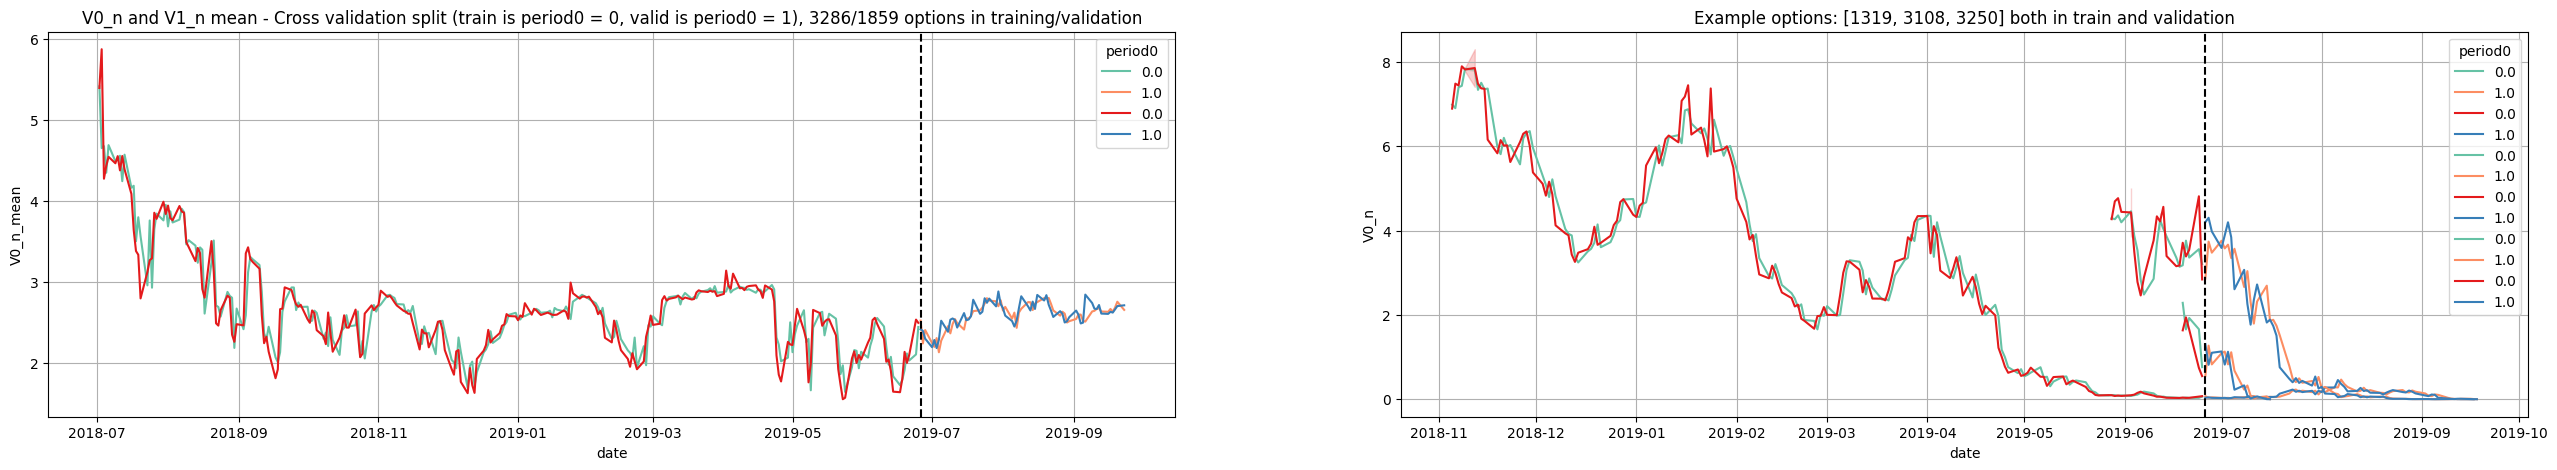

In [15]:
overlap_pd = df_train_raw[df_train_raw["optionid"].isin(overlap_options)].groupby(["optionid", "period0"])["date"].count().reset_index()
# fig, ax = plt.subplots(1, 1, figsize=(32,5))
# d = sns.barplot(data=overlap_pd, x="optionid", y="date", hue="period0", ax=ax)
# d = ax.set_title("Overlap of options, both in train + validation")
df_cv = df_train_raw.groupby(["date"]).agg(V0_n_mean=("V0_n", "mean"), V1_n_mean=("V1_n", "mean"), period0=("period0", "max")).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(32,5))
d = sns.lineplot(data=df_cv, x="date", y="V0_n_mean", hue="period0", palette="Set2", ax=ax[0])
d = sns.lineplot(data=df_cv, x="date", y="V1_n_mean", hue="period0", palette="Set1", ax=ax[0])
d = ax[0].grid()
d = ax[0].axvline(df_val["date"].min(), color="black", linestyle="--")
d = ax[0].set_title("V0_n and V1_n mean - Cross validation split (train is period0 = 0, valid is period0 = 1), %d/%d options in training/validation" % (df_train["optionid"].nunique(), df_val["optionid"].nunique()))

options = [1319, 3108, 3250]
for option in options:
    data_option = df_train_raw[df_train_raw["optionid"] == option].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V0_n", ax=ax[1], palette="Set2", hue="period0")
    d = sns.lineplot(data=data_option, x="date", y="V1_n", ax=ax[1], palette="Set1", hue="period0")
d = ax[1].axvline(df_val["date"].min(), color="black", linestyle="--")
d = ax[1].set_title("Example options: %s both in train and validation" % options)
d = ax[1].grid()

In [16]:
# list(df_val[~df_val["optionid"].isin(overlap_options)]["optionid"].unique())

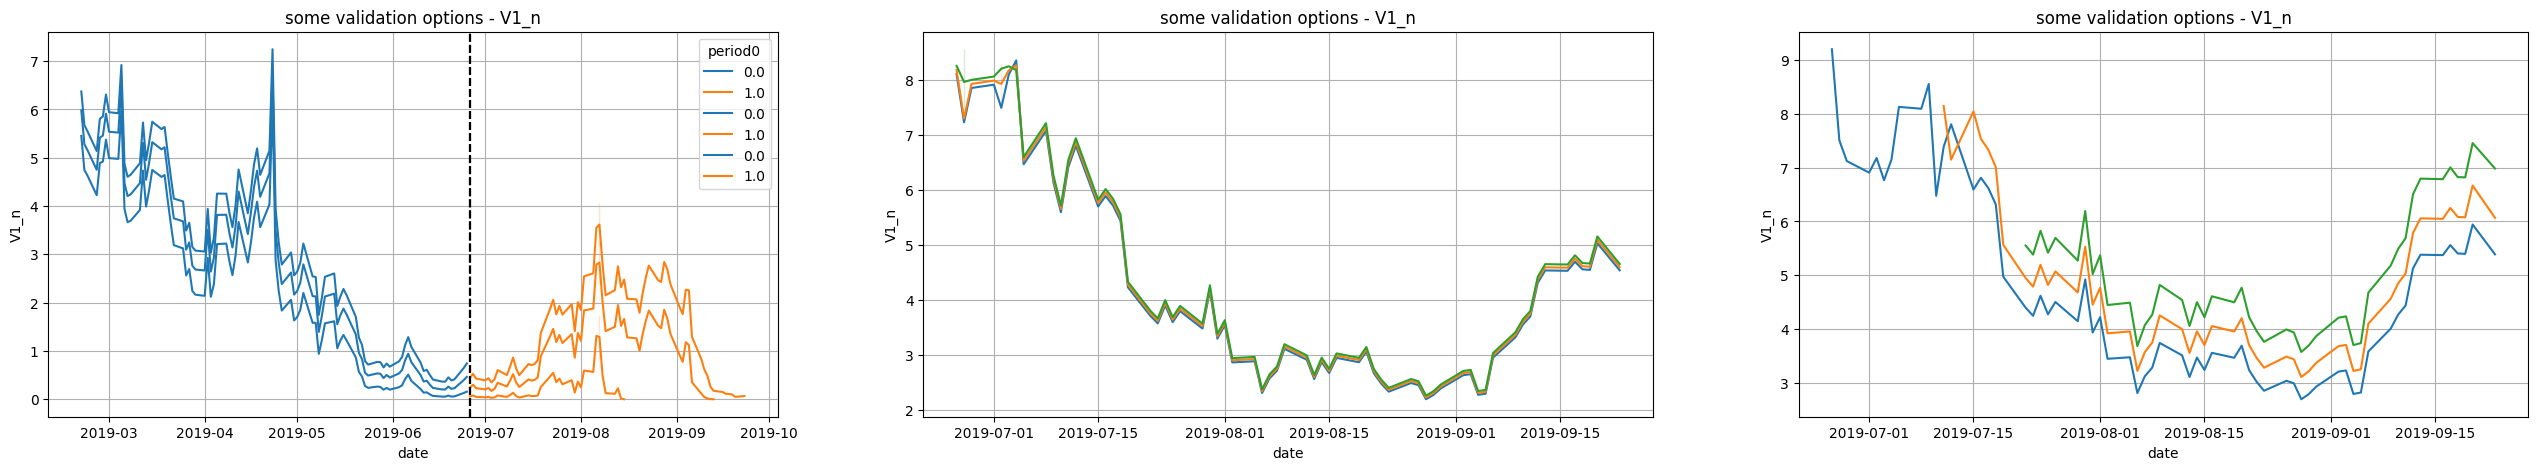

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(32,5))
for optionid in [1925, 1928, 1931]:
    data_option = df_train_raw[df_train_raw["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", ax=ax[0], hue="period0")
    d = ax[0].grid()
    d = ax[0].axvline(df_val["date"].min(), color="black", linestyle="--")
    d = ax[0].set_title('some validation options - V1_n')

for optionid in [3287, 3288, 3289]:
    data_option = df_train_raw[df_train_raw["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", ax=ax[1])
    d = ax[1].grid()
    d = ax[1].set_title('some validation options - V1_n')

for optionid in [3301, 3311, 3321]:
    data_option = df_train_raw[df_train_raw["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", ax=ax[2])
    d = ax[2].grid()
    d = ax[2].set_title('some validation options - V1_n')

## Choose features and standardize

In [ ]:
# Scaled features
scaler = StandardScaler().fit(df_train[config.orig_features])
print(scaler.mean_)
df_train[config.transformed_features] = scaler.transform(df_train[config.orig_features])
df_val[config.transformed_features] = scaler.transform(df_val[config.orig_features])

In [19]:
df_val.head()

,date,S0,K,tau0,optionid,short_rate,M0,r,implvol0,V0,cp_int,S1,V1,implvol1,S0_n,V0_n,K_n,S1_n,V1_n,delta_bs,vega_n,gamma_n,vanna_n,Is_In_Some_Test,on_ret,period0,tau0_implvol0,sqrt_tau0,1_over_sqrt_tau,vega_s,delta_vega_s,delta2_vega_s,delta_bs_t,1_over_sqrt_tau_t,vega_n_t,vanna_n_t
262515,2019-08-07,2674.19199,2675.0,0.027668,1925,0.0,0.999698,0.0,0.2,35.092442,0,2699.204472,46.519968,0.2,100.0,1.312263,100.030215,100.935329,1.739590,0.503013,6.635695,0.119916,0.051292,False,1.0,1.0,0.033267,0.166337,6.011893,0.398931,0.200667,0.100938,2.173914,3.389733,-1.074712,0.774892
262949,2019-08-07,2674.19199,2675.0,0.126482,1928,0.0,0.999698,0.0,0.2,75.475651,0,2699.204472,87.755875,0.2,100.0,2.822372,100.030215,100.935329,3.281585,0.512492,14.181162,0.056060,0.079374,False,1.0,1.0,0.071129,0.355643,2.811805,0.398747,0.204354,0.104730,2.207502,0.754653,-0.416928,0.823669
263412,2019-08-07,2674.19199,2675.0,0.205534,1931,0.0,0.999698,0.0,0.2,96.310880,0,2699.204472,108.814049,0.2,100.0,3.601495,100.030215,100.935329,4.069044,0.516752,18.070425,0.043960,0.096992,False,1.0,1.0,0.090672,0.453358,2.205762,0.398591,0.205973,0.106437,2.222599,0.255613,-0.077877,0.854273
263877,2019-08-07,2674.19199,2675.0,0.284585,1934,0.0,0.999698,0.0,0.2,113.384929,0,2699.204472,126.036517,0.2,100.0,4.239970,100.030215,100.935329,4.713069,0.520144,21.255041,0.037344,0.111916,False,1.0,1.0,0.106693,0.533465,1.874537,0.398434,0.207243,0.107796,2.234618,-0.017131,0.199745,0.880196
264342,2019-08-07,2674.19199,2675.0,0.383399,1937,0.0,0.999698,0.0,0.2,131.648823,0,2699.204472,144.439554,0.2,100.0,4.922938,100.030215,100.935329,5.401241,0.523715,24.658545,0.032158,0.128150,False,1.0,1.0,0.123838,0.619192,1.615007,0.398237,0.208563,0.109227,2.247272,-0.230838,0.496449,0.908394


#### Train model

In [ ]:
output_dir = os.path.join(config.default_root_dir, "seed%d" % config.seed)
os.makedirs(output_dir, exist_ok=True)

# Save Scaler
save_object(scaler, os.path.join(output_dir, "scaler.pkl"))

model = HedgeNet(config)

# Train/Validation Datasets
train_dataset = HedgeDataset(df_train, use_features=config.use_features)
valid_dataset = HedgeDataset(df_val, use_features=config.use_features)

# Train/Validation Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, drop_last=False, num_workers=config.num_workers, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=config.eval_batch_size, drop_last=False, num_workers=config.num_workers, shuffle=False, pin_memory=True)

monitor = "val_mse"
logger_wandb = WandbLogger(project=config.report_name, name=output_dir.replace("/", "_")) if config.report_to != "none" else None
logger_csv = CSVLogger("./logs", name=output_dir.replace("/", "_"))
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(dirpath=output_dir, monitor=monitor, mode='min', filename='best_{epoch}-{%s:.5f}' % monitor, save_top_k=1, save_last=False, save_weights_only=True)
callbacks = [lr_monitor]

if config.ema is not None:
    print("EMA enabled:", config.ema)
    ema = EMA(config.ema)
    callbacks.extend([ema])
    checkpoint_callback = NeMoModelCheckpoint(dirpath=output_dir, monitor="val_mse", mode='min',
                                              filename='best_{epoch}-{val_mse:.5f}',
                                              save_top_k=config.save_top_k, save_last=True,
                                              save_weights_only=True, save_nemo_on_train_end=False)
callbacks.extend([checkpoint_callback])

d = save_config(config, os.path.join(output_dir, "pl-config.json"))
print("Train:", df_train.shape, "Valid:", df_val.shape, "LR", config.lr, "Loss", model.loss)
print("Features:", config.use_features, "Train dataset first item:", train_dataset[0])

trainer = L.Trainer(
    default_root_dir=output_dir,
    max_epochs=config.train_epochs,
    accelerator=config.device,
    deterministic=config.deterministic,
    precision=config.precision,
    logger=logger_wandb if logger_wandb is not None else logger_csv,
    callbacks=callbacks,
    val_check_interval=1.0,
    enable_progress_bar=True,
)

trainer.fit(model, train_dataloader, valid_dataloader)

if logger_wandb is not None:
    wandb.finish()

## Infer model on validation data

In [ ]:
output_dir = os.path.join(config.default_root_dir, "seed%d" % config.seed)

df_val_copy = df_val.copy()

# Train/Validation Datasets
valid_dataset = HedgeDataset(df_val_copy, use_features=config.use_features)
valid_dataloader = DataLoader(valid_dataset, batch_size=config.eval_batch_size, drop_last=False, num_workers=config.num_workers, shuffle=False, pin_memory=True)

# Load trained model
pattern = "best_epoch*.ckpt" if config.ema is None else "best_epoch*EMA.ckpt"
best_weights = glob.glob(output_dir + "/" + pattern)[0]
print("Loading", best_weights)
model = HedgeNet(config)
model_dump = torch.load(best_weights, map_location='cpu')
model.load_state_dict(model_dump["state_dict"])
model.eval()

# Predict V1 and delta
trainer = L.Trainer()
results = trainer.predict(model, valid_dataloader)
logits = torch.vstack([r[0] for r in results]).cpu().numpy().squeeze()
delta = torch.vstack([r[1] for r in results]).cpu().numpy().squeeze()
print("delta", delta.shape)
df_val_copy["v1_pred"] = logits
df_val_copy["delta_pred"] = delta

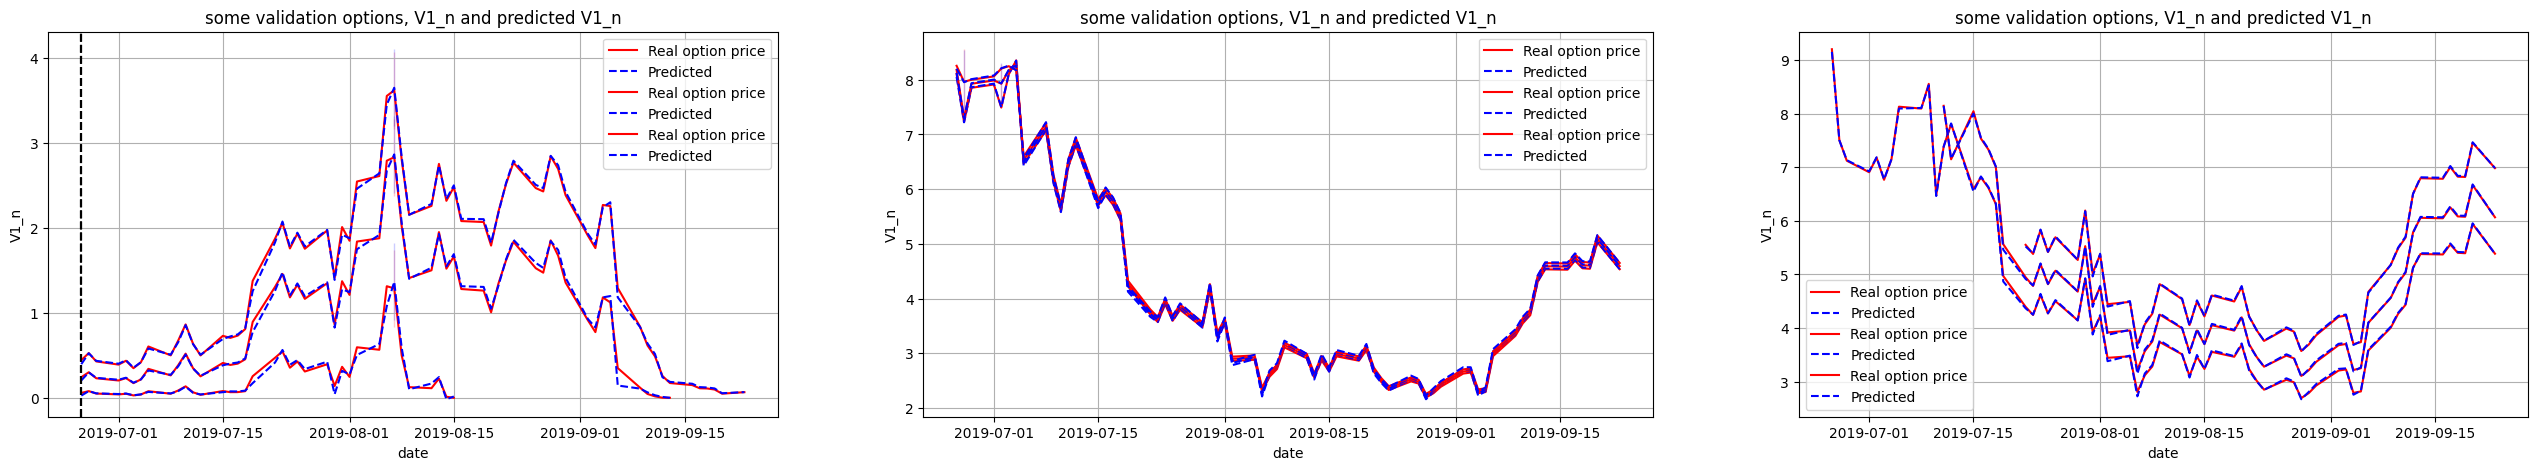

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(32,5))
for optionid in [1925, 1928, 1931]:
    data_option = df_val_copy[df_val_copy["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", color="red", ax=ax[0], label="Real option price")
    d = sns.lineplot(data=data_option, x="date", y="v1_pred", color="blue", linestyle="--", ax=ax[0], label="Predicted")
    d = ax[0].grid()
    d = ax[0].axvline(df_val["date"].min(), color="black", linestyle="--")
    d = ax[0].set_title('some validation options, V1_n and predicted V1_n')

for optionid in [3287, 3288, 3289]:
    data_option = df_val_copy[df_val_copy["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", color="red", ax=ax[1], label="Real option price")
    d = sns.lineplot(data=data_option, x="date", y="v1_pred", color="blue", linestyle="--", ax=ax[1], label="Predicted")
    d = ax[1].grid()
    d = ax[1].set_title('some validation options, V1_n and predicted V1_n')

for optionid in [3301, 3311, 3321]:
    data_option = df_val_copy[df_val_copy["optionid"] == optionid].reset_index(drop=True)
    d = sns.lineplot(data=data_option, x="date", y="V1_n", color="red", ax=ax[2], label="Real option price")
    d = sns.lineplot(data=data_option, x="date", y="v1_pred", color="blue", linestyle="--", ax=ax[2], label="Predicted")
    d = ax[2].grid()
    d = ax[2].set_title('some validation options, V1_n and predicted V1_n')

## Infer model on test data

#### Load and prepare test data

In [23]:
def make_features(df):
    # Make sure this function is called after copying calls for puts.
    # because delta are different for calls and puts.
    df = df.copy()
    df['tau0_implvol0'] = np.sqrt(df['tau0']) * df['implvol0']
    df['sqrt_tau0'] = np.sqrt(df['tau0'])
    df['1_over_sqrt_tau'] = 1 / np.sqrt(df['tau0'])
    
    # the following three features are used for Hull-White regression.
    df['vega_s'] = df['vega_n'] / (df['S0_n'] * np.sqrt(df['tau0']))
    df['delta_vega_s'] = df['delta_bs'] * df['vega_s']
    df['delta2_vega_s'] = (df['delta_bs']**2) * df['vega_s']
    
    return df

def remove_cols_rename(df, whole_dict, single_key, future_volume=None):
    remove_freq = whole_dict.copy()
    remove_freq.pop(single_key)

    for key, value in remove_freq.items():
        tag = value[1]
        remove_cols = [x for x in df.columns if tag in x]
        for col in remove_cols:
            del df[col]

    tmp = {
        f'S{whole_dict[single_key][1]}': 'S1',
        f'V{whole_dict[single_key][1]}': 'V1',
        f'V{whole_dict[single_key][1]}_atm': 'V1_atm',
        f'implvol{whole_dict[single_key][1]}': 'implvol1',
        f'S{whole_dict[single_key][1]}_n': 'S1_n',
        f'V{whole_dict[single_key][1]}_n': 'V1_n',
        f'V{whole_dict[single_key][1]}_atm_n': 'V1_atm_n'
    }

    if future_volume:
        tmp[f'volume{whole_dict[single_key][1]}'] = 'volume1'
    df.rename(columns=tmp, inplace=True)

def tag_data(
        df, tag=None, period=None, 
        offset=None,
        start_date=None, 
        end_date=None
    ):
    """
    Here, we tag for train, validation and test set.
    tag = 0, 1, 2 for train, validation and test respectively.
    The outcoming period will be from the start date to (end_date - business offset)
    """
    if isinstance(offset, pd.Timedelta):
        if offset <= pd.Timedelta('2 hours'):
            t_end = end_date
    else:
        t_end = end_date - offset
    bl = (df['date'] >= start_date) & (df['date'] <= t_end)
    df.loc[bl, f'period{period}'] = tag

def choose_half_shrink_moneyness(df, ori_size, half, min_m, max_m):
    """ Choose in-the-money, out-of-money or both """
    if half == 'otm':
        df = out_of_money_only(df, ori_size)
    elif half == 'itm':
        df = in_the_money_only(df, ori_size)
    elif half == 'both':
        pass
    else:
        raise NotImplementedError('In-the-money or out-of-money')

    bl = (df['M0'] >= min_m-0.001) & (df['M0'] <= max_m+0.001)
    print_removal(df.shape[0], sum(bl), ori_size, 'We shrink moneyness range')
    df = df.loc[bl]
    
    return df

def print_removal(before_size, cur_size, ori_size, issue):
    print(f'{issue}. {before_size - cur_size} samples ({(before_size - cur_size)/before_size* 100:.2f}%) are removed. We have {cur_size / ori_size * 100:.2f}% of original data left, yielding a size of {cur_size}.')

def out_of_money_only(df, ori_size):
    bl = ((df['cp_int'] == 0) & (df['M0'] < 1.001)) | ((df['cp_int'] == 1) & (df['M0'] > 0.999))
    print_removal(df.shape[0], sum(bl), ori_size, 'We remove in-the-money samples')
    df = df.loc[bl]
    return df

def in_the_money_only(df, ori_size):
    bl = ((df['cp_int'] == 0) & (df['M0'] > 0.999)) | ((df['cp_int'] == 1) & (df['M0'] < 1.001))
    print_removal(df.shape[0], sum(bl), ori_size, 'We remove out-of-money samples')
    df = df.loc[bl]
    return df

# Prepare MC data from CSV
mc_sets = []
for i in range(config.num_tests):
    print('Load Monte Carlo set', i+1)
    df_test = pd.read_csv(os.path.join(config.mc_dir, 'mc{}.csv'.format(i)), index_col=0, parse_dates=['date'])
    print(df_test.shape)
    
    remove_cols_rename(df_test, config.OFFSET_DICT, config.FREQ)
    df_test['on_ret'] = np.exp(df_test['short_rate'] * config.DT)
    
    tag_data(
        df_test, tag=2, period=0,
        offset=BDay(config.OFFSET_DICT[config.FREQ][0]),
        start_date=df_test['date'].min(),
        end_date=df_test['date'].max()
    )
    ori_size = df_test.shape[0]

    df_test = choose_half_shrink_moneyness(df_test, ori_size, config.HALF_MONEY, config.MIN_M, config.MAX_M)
    bl = df_test['V1'].notna()
    print_removal(df_test.shape[0], sum(bl), ori_size, 'We remove samples when S1 is not available')
    df_test = df_test.loc[bl]
    df_test = make_features(df_test)
    mc_sets.append(df_test.copy())

Load Monte Carlo set 1
(206091, 47)
We remove in-the-money samples. 107339 samples (52.08%) are removed. We have 47.92% of original data left, yielding a size of 98752.
We shrink moneyness range. 0 samples (0.00%) are removed. We have 47.92% of original data left, yielding a size of 98752.
We remove samples when S1 is not available. 1965 samples (1.99%) are removed. We have 46.96% of original data left, yielding a size of 96787.
Load Monte Carlo set 2
(177074, 47)
We remove in-the-money samples. 89417 samples (50.50%) are removed. We have 49.50% of original data left, yielding a size of 87657.
We shrink moneyness range. 0 samples (0.00%) are removed. We have 49.50% of original data left, yielding a size of 87657.
We remove samples when S1 is not available. 1208 samples (1.38%) are removed. We have 48.82% of original data left, yielding a size of 86449.
Load Monte Carlo set 3
(183459, 47)
We remove in-the-money samples. 93677 samples (51.06%) are removed. We have 48.94% of original data

In [24]:
def calc_pnl(df, delta, V1='V1_n'):
    """
    This method calculates PnL. We assume short option.
    :param V1: Target to compare to.
    :return: Series pnl
    """
    s0, s1 = df['S0_n'], df['S1_n']
    v0, v1 = df['V0_n'], df[V1]
    on_return = df['on_ret']

    # print("df", df.shape, "s0", s0.shape, "s1", s1.shape, "v0", v0.shape, "v1", v1.shape, "on_return", on_return.shape, delta.shape)
    
    v1_hat = (v0 - delta * s0) * on_return + delta * s1
    return (v1_hat - v1)

def get_pnl(df, delta, V1='V1_n'):
    delta = delta[df['Is_In_Some_Test']]
    df = df[df['Is_In_Some_Test']]

    # Cap or floor PNL by security type
    bl_c = df['cp_int'] == 0
    delta[bl_c] = np.maximum(delta[bl_c], 0.)
    delta[~bl_c] = np.minimum(delta[~bl_c], 0.)

    cols = [x for x in df.columns if x in ['ExecuteTime0', 'Aggressorside']]
    cols += ['cp_int', 'date']
    df_res = df[cols].copy()
    df_res['delta'] = delta
    df_res['PNL'] = calc_pnl(df, delta, V1=V1)
    df_res['M0'] = df['M0'].copy()
    df_res['tau0'] = df['tau0'].copy()
    
    df_res['testperiod'] = np.nan
    # In addition, we want to record which test period the pnl is from.
    max_period = max([int(s[6:]) for s in df.columns if 'period' in s])
    for i in range(0, max_period + 1):
        bl = df['period{}'.format(i)] == 2
        df_res.loc[bl, 'testperiod'] = i
        
    return df_res

#### Run inference

In [ ]:
output_dir = os.path.join(config.default_root_dir, "seed%d" % config.seed)

# Load Scaler
scaler = load_object(os.path.join(output_dir, "scaler.pkl"))

for i in range(config.num_tests):
    # Load MC data
    df_test = mc_sets[i]
    # Standardize
    df_test[config.transformed_features] = scaler.transform(df_test[config.orig_features])

    test_dataset = HedgeDataset(df_test, use_features=config.use_features)
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, drop_last=False, num_workers=config.num_workers, shuffle=False, pin_memory=True)

    # Load trained model
    pattern = "best_epoch*.ckpt" if config.ema is None else "best_epoch*EMA.ckpt"
    best_weights = glob.glob(output_dir + "/" + pattern)[0]
    print("Loading", best_weights)
    model = HedgeNet(config)
    model_dump = torch.load(best_weights, map_location='cpu')
    model.load_state_dict(model_dump["state_dict"])
    model.eval()

    # Predict V1 and delta
    trainer = L.Trainer()
    results = trainer.predict(model, test_dataloader)
    logits = torch.vstack([r[0] for r in results]).cpu().numpy().squeeze()
    delta = torch.vstack([r[1] for r in results]).cpu().numpy().squeeze()
    print("delta", delta.shape)

    df_pnl = get_pnl(df_test, delta)
    df_pnl.to_csv(os.path.join(output_dir, f'pnl{i}.csv'))

    # break